# Connect 4 AI: A Modified AlphaZero Approach

## Objective
The goal of this notebook is to implement a modified version of the AlphaZero algorithm for the game of Connect 4. While inspired by the original AlphaZero paper ([Adaptive AlphaZero methodology](https://arxiv.org/abs/1712.01815)), our implementation makes several key adaptations to suit this simpler game environment.

## Key Differences from Original AlphaZero
- **Simpler Network Architecture**: Our implementation uses a lighter neural network structure, appropriate for Connect 4's smaller state space compared to Go or Chess
- **Modified MCTS**: Adapted the search algorithm for Connect 4's specific game tree characteristics
- **Training Process**: Uses shorter training cycles and different hyperparameters due to Connect 4's reduced complexity
- **Resource Optimization**: Designed for running on standard hardware rather than the massive TPU clusters used in the original paper

## Implementation Components

### 1. Game Environment
- Utilizing Kaggle's ConnectX environment instead of building a custom engine
- Provides standardized interface for agent interaction
- Handles game rules and state management

### 2. Neural Network Design
```python
class Alpha_Net(torch.nn.Module):
    # Our simplified network architecture
    # Combines policy (move selection) and value (position evaluation)
```

### 3. Self-Play Training
- Uses MCTS guided by neural network predictions
- Generates training data through self-play
- Implements parallel game simulation for efficiency
```python
def self_play(net, search=70, gamma=0.95, random_turn=3):
    # Modified self-play implementation
```

### 4. Training Process
- Updates network weights using experience replay
- Combines policy and value loss functions
- Implements regular evaluation against benchmark opponents
```python
class AlphaN():
    # Our training implementation
    def train(self, num, play_num=40, batch_num=32, ...):
```

### 5. Evaluation
- Regular testing against deterministic opponents
- Tracks multiple performance metrics
- Visualizes learning progress through loss curves

This implementation prioritizes practicality and efficiency while maintaining the core principles of the AlphaZero methodology. It demonstrates how the algorithm can be adapted for simpler games while still achieving strong performance.

https://arxiv.org/abs/1712.01815.

# Library Imports for ConnectX Environment and Machine Learning

This code block imports essential libraries and modules needed for working with the ConnectX game environment and implementing machine learning solutions:

- **Game Environment Libraries:**
  - `kaggle_environments`: Provides tools for the ConnectX game environment
  - `play` and `is_win`: Specific functions for game mechanics and win detection
  
- **Data Visualization and Numerical Computing:**
  - `matplotlib.pyplot`: For creating visualizations and plots
  - `numpy`: For efficient numerical computations and array operations
  
- **Machine Learning and Neural Networks:**
  - `torch`: PyTorch library for deep learning implementations
  
- **Utility Libraries:**
  - `time`: For timing and performance measurements
  - `random`: For generating random numbers and selections
  - `collections`: For specialized container datatypes
  - `joblib`: For parallel processing and efficient data persistence

In [28]:
from kaggle_environments import evaluate, make, utils
from kaggle_environments.envs.connectx.connectx import play,is_win
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import random
import collections
from joblib import Parallel, delayed
import joblib

Neural Network Architecture for ConnectX Game
This code block defines a custom neural network architecture (Alpha_Net) using PyTorch for the ConnectX game. Here's a detailed breakdown of its structure:

Input Processing (Block 1):

Takes a 2-channel input
Uses three convolutional layers with increasing filters (20 → 40 → 120)
Each conv layer is followed by BatchNormalization and LeakyReLU activation
Kernel sizes: 2x2 → 3x3 → 3x3


Policy Head (Block 2):

Flattens convolutional output to 240 features
Two fully connected layers: 240 → 42 → 7 neurons
Uses LogSoftmax during training and Softmax during evaluation
Output represents move probabilities for the 7 possible columns


Value Head (Block 3):

Parallel branch from the flattened features
Two fully connected layers: 240 → 16 → 1
Uses Tanh activation for final output
Estimates game position value in range [-1, 1]



This architecture follows an AlphaZero-style design with dual outputs:

Policy output (7 values) for move selection
Value output (1 value) for position evaluation

The network demonstrates a modern deep learning approach with proper normalization, non-linear activations, and separate training/evaluation behavior. CopyRetry

In [29]:
class Alpha_Net(torch.nn.Module):
    def __init__(self):
        super(Alpha_Net,self).__init__()
        self.block1 = torch.nn.Sequential(
        torch.nn.Conv2d(2,20,kernel_size=2,padding=0,stride=1),
        torch.nn.BatchNorm2d(20),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(20,40,kernel_size=3,padding=0,stride=1),
        torch.nn.BatchNorm2d(40),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(40,120,kernel_size=3,padding=0,stride=1),
        torch.nn.BatchNorm2d(120),
        torch.nn.LeakyReLU(),
        )
        self.block2 = torch.nn.Sequential(
        torch.nn.Linear(240, 42),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(42, 7),
        )
        self.t_out = torch.nn.LogSoftmax(dim=1)
        self.e_out = torch.nn.Softmax(dim=1)
        self.block3 = torch.nn.Sequential(
        torch.nn.Linear(240, 16),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(16, 1),
        torch.nn.Tanh()
        )

    def forward(self, x):
        x = self.block1(x)
        x = x.view(-1,240)
        x1 = self.block2(x)
        if self.training:
            x1 = self.t_out(x1)
        else:
            x1 = self.e_out(x1)
        x2 = self.block3(x)
        x = torch.cat([x1,x2],dim=1)
        return x

# Monte Carlo Tree Search (MCTS) Implementation for ConnectX

This code implements an AlphaZero-style MCTS algorithm for the ConnectX game. Here's a detailed breakdown of its functionality:

- **Input Parameters:**
  - `net`: Neural network model for policy and value predictions
  - `board`: Current game state
  - `config`: Game configuration
  - Additional parameters for search control (C_p, time_lim, gamma, steps)

- **State Representation:**
  - Converts board state into two binary channels:
    - Channel 1: Positions of player 1's pieces
    - Channel 2: Positions of player 2's pieces
  - Uses neural network to get initial policy and value estimates

- **MCTS Components:**
  - **Tree Search Structure:**
    - Maintains counts, Q-values, and policy values for each move
    - Uses UCB1-style selection formula with exploration constant C_p
    - Implements progressive widening through expand_threshold
  
  - **Search Process:**
    - Root node: Performs full MCTS for specified steps or time limit
    - Non-root nodes: Single step expansion with value backup
    - Handles terminal states (wins, draws) appropriately

- **Key Features:**
  - Time-based cutoff for search depth
  - Gamma discount factor for future rewards
  - Progressive widening of search tree
  - Dynamic exploration-exploitation balance
  - Value mixing between network evaluation and search results

This implementation combines traditional MCTS with neural network guidance, similar to AlphaZero's approach, to create a strong game-playing agent for ConnectX.

In [30]:
def alpha_MCTS(net,board,config,start_time=None,info=None,expand=False,root=False,C_p=1000,expand_threshold=1,time_lim=4.0,gamma=0.95,steps=350):#parameter C_p should be tuned
    if info == None:
        b1 = np.array([[[1 if p == 1 else 0 for p in board]]]).reshape(1,1,6,7)
        b2 = np.array([[[1 if p == 2 else 0 for p in board]]]).reshape(1,1,6,7)
        board2 = np.concatenate([b1,b2],axis=1)
        board2 = torch.from_numpy(board2).float()
        pred = net(board2).detach().numpy()[0]
        policy = pred[:7]
        value = pred[7]
        count = [0,0,0,0,0,0,0]
        info_each = [0,0,0,0,0,0,0]
        Q = [0,0,0,0,0,0,0]
    else:
        policy = info['policy']
        info_each = info['info_each']
        count = info['count']
        Q = info['Q']
        value = info['value']
    turn = sum([1 if p != 0 else 0 for p in board])%2 + 1
    if root:
        start_time = time.time()
        for t in range(steps):
            C = np.log((1+sum(count)+C_p)/C_p) + 1.25
            select = np.array([Q[i]+C*policy[i]*(np.sqrt(sum(count))/(1+count[i])) for i in range(7)])
            child_index = int(np.argmax(select))
            if board[child_index] != 0:
                Q[child_index] = -1
            else:
                next_board = board[:]
                if is_win(next_board,child_index,turn,config,False):
                    Q[child_index] = 1
                else:
                    play(next_board,child_index,turn,config)
                    fillness = sum([1 if p != 0 else 0 for p in next_board])
                    if fillness == 42:
                        Q[child_index] = 0
                    else:
                        if count[child_index] >= expand_threshold:
                            scc, ie = alpha_MCTS(net,next_board,config,start_time,expand=True,info=info_each[child_index])
                            Q[child_index] = -scc
                            info_each[child_index] = ie
                        else:
                            if count[child_index] == 0:
                                scc, pol = alpha_MCTS(net,next_board,config,start_time,info=None)
                                Q[child_index] = -scc
                                info_each[child_index] = {'policy':pol,'info_each':[0,0,0,0,0,0,0],'count':[0,0,0,0,0,0,0],'Q':[0,0,0,0,0,0,0],'value':scc}
            count[child_index] += 1
            if time.time()-start_time >= time_lim:
                break
        return np.power(np.array(count),1) / np.power(np.array(count),1).sum(), np.sum(np.array(Q) * np.array(count)) / sum(count)
    else:
        if expand:
            C = np.log((1+sum(count)+C_p)/C_p) + 1.25
            select = np.array([Q[i]+C*policy[i]*(np.sqrt(sum(count))/(1+count[i])) for i in range(7)])
            child_index = int(np.argmax(select))
            if board[child_index] != 0:
                Q[child_index] = -1
            else:
                next_board = board[:]
                if is_win(next_board,child_index,turn,config,False):
                    Q[child_index] = 1
                else:
                    play(next_board,child_index,turn,config)
                    fillness = sum([1 if p != 0 else 0 for p in next_board])
                    if fillness == 42:
                        Q[child_index] = 0
                    else:
                        if count[child_index] >= expand_threshold:
                            scc, ie = alpha_MCTS(net,next_board,config,start_time,expand=True,info=info_each[child_index])
                            Q[child_index] = -gamma*scc
                            info_each[child_index] = ie
                        else:
                            if count[child_index] == 0:
                                scc, pol = alpha_MCTS(net,next_board,config,start_time,info=None)
                                Q[child_index] = -gamma*scc
                                info_each[child_index] = {'policy':pol,'info_each':[0,0,0,0,0,0,0],'count':[0,0,0,0,0,0,0],'Q':[0,0,0,0,0,0,0],'value':scc}
            count[child_index] += 1
            re_Q = np.array(Q) * np.array(count)
            r = np.power(2,sum(count)-1)/(1+np.power(2,sum(count)-1))
            return np.sum(re_Q)/sum(count)*r + value*(1-r), {'policy':policy,'info_each':info_each,'count':count,'Q':Q,'value':value}
        else:
            return value, policy

# Self-Play Training and Evaluation Functions for ConnectX

Let me break down these three important functions:

### 1. Self-Play Training Function
```python
def self_play(net, search=70, gamma=0.95, random_turn=3):
```
This function implements self-play training for the ConnectX agent:

- **Purpose:** Generates training data through self-play matches
- **Key Features:**
  - Creates game environment using Kaggle's ConnectX
  - Records board states, policies, and rewards
  - Implements data augmentation through board reflection
  - Uses MCTS for move selection
  - Adds randomization in early game moves
- **Returns:** List of gameplay experiences with augmented data

### 2. Custom Loss Function
```python
class original_loss(torch.nn.Module):
```
Defines the training loss for the neural network:

- **Components:**
  - Cross Entropy Loss (CEL) for policy prediction
  - Mean Squared Error (MSE) for value prediction
  - Combines both losses into a single objective
- **Input:** Network predictions and target values
- **Output:** Both individual losses (CEL and MSE)

### 3. Evaluation Function
```python
def fight(agent, fs, mode="random"):
```
Implements agent evaluation against different opponents:

- **Purpose:** Tests agent performance in actual gameplay
- **Parameters:**
  - `agent`: The AI player to evaluate
  - `fs`: First/second player flag
  - `mode`: Opponent type (default: "random")
- **Process:** 
  - Sets up game environment
  - Runs a complete game
  - Returns final reward
- **Maximum Steps:** 42 (full board)

These functions together form a complete training and evaluation pipeline for the ConnectX agent, following principles similar to AlphaZero's training methodology.

In [31]:
def self_play(net,search=70,gamma=0.95,random_turn=3):
    env = make('connectx',debug=True)
    log = []
    log2 = []
    turn = 0
    while True:
        turn += 1
        p_log = {}
        b1 = np.array([[[1 if p == 1 else 0 for p in env.state[0]['observation']['board']]]]).reshape(1,1,6,7)
        b2 = np.array([[[1 if p == 2 else 0 for p in env.state[0]['observation']['board']]]]).reshape(1,1,6,7)
        board = np.concatenate([b1,b2],axis=1)
        liner_board = env.state[0]['observation']['board']
        p_log['board'] = board[0]
        pol, value = alpha_MCTS(net,liner_board,env.configuration,root=True,steps=search)
        p_log['policy'] = pol
        p_log['reward'] = value  ##different from AlphaZero
        log.append(p_log)
        action = random.choices([0,1,2,3,4,5,6],weights=list(pol),k=1)[0]
        if liner_board[action] != 0 or turn < random_turn:
            action = random.choice([c for c in range(7) if liner_board[c] == 0])
        env.step([action,action])
        if env.state[0]['status'] == 'DONE':
            break
    #Augmentation by reflection
    for i in range(len(log)):
        b = log[i]['board']
        board2 = np.array([np.fliplr(b[0]),np.fliplr(b[1])]).copy()
        policy2 = log[i]['policy'][::-1].copy()
        log2.append({'board':board2,'policy':policy2,'reward':log[i]['reward']})
    log = log + log2
    return log

In [32]:
class original_loss(torch.nn.Module):
    def __init__(self):
        super(original_loss,self).__init__()
    def forward(self,pred,target):
        CEL = (-target[:,:7] * pred[:,:7]).sum(dim=1).sum()
        MSE = torch.pow((target[:,7]-pred[:,7]),2).sum()
        loss = CEL+MSE
        return CEL,MSE

In [33]:
def fight(agent,fs,mode="random"):
    env = make('connectx',debug=True)
    if fs == 1:
        trainer = env.train([None,mode])
    else:
        trainer = env.train([mode,None])
    observation = trainer.reset()
    done = False
    for step in range(42):
        action = agent(observation, env.configuration)
        observation, reward, done, info = trainer.step(action)
        if done:
            break
    return reward

# AlphaN Class - Main Training Pipeline for ConnectX AI

This class implements the complete training pipeline for the ConnectX AI agent, following AlphaZero principles. Here's a detailed breakdown:

- **Initialization Components:**
  - Neural network model (Alpha_Net)
  - Experience replay buffer (deque with 100k max size)
  - RMSprop optimizer
  - Custom loss function
  - Performance logging lists
  - Game environment

- **Key Methods:**
  1. **evaluate Method:**
     - Parallel evaluation against specified opponent
     - Tests agent as both first and second player
     - Returns average performance scores
     - Uses joblib for parallel processing
  
  2. **train Method:**
     - Core training loop with these phases:
        - Self-play data generation (parallel)
        - Neural network updates
        - Periodic evaluation
     - Parameters:
        - `num`: Total training iterations
        - `play_num`: Self-play games per iteration
        - `batch_num`: Number of batches per update
        - `batch_size`: Samples per batch
        - `train_loop`: Training iterations per update
        - `time_lim`: Maximum training time

- **Training Process Features:**
  - Initial large-scale self-play (1000 games) for buffer initialization
  - Regular evaluation against negamax opponent
  - Experience replay for stable learning
  - Gradient computation with anomaly detection
  - Progress visualization with matplotlib
  - Time-based training cutoff

This class represents a complete implementation of an AlphaZero-style learning system, combining self-play, supervised learning, and evaluation in an integrated training pipeline.

In [34]:
class AlphaN():
    def __init__(self):
        self.net = Alpha_Net()
        self.buff = collections.deque([],maxlen=100000)
        self.optim = torch.optim.RMSprop(self.net.parameters(),lr=0.001,weight_decay=1e-4)
        self.criterion = original_loss()
        self.loss_log = []
        self.CEL_log = []
        self.MSE_log = []
        self.score_log = []
        self.env = make("connectx", debug=True)
    def evaluate(self,num,mode='random'):
        def forward(observation, configuration):
            policy,_ = alpha_MCTS(self.net,observation.board,configuration,root=True,steps=70)
            action = random.choices([0,1,2,3,4,5,6],weights=list(policy),k=1)[0]
            if observation.board[action] != 0:
                action = random.choice([c for c in range(configuration.columns) if observation.board[c] == 0])
            return action
        result1 = Parallel(n_jobs=-1,verbose=0)([delayed(fight)(forward,fs=1,mode=mode) for n in range(num)])
        result2 = Parallel(n_jobs=-1,verbose=0)([delayed(fight)(forward,fs=2,mode=mode) for n in range(num)])
        reward1 = sum(result1)
        reward2 = sum(result2)
        return reward1 / num, reward2 / num
    def train(self,num,play_num=40,batch_num=32,batch_size=64,train_loop=50,time_lim=30000):
        start_time = time.time()
        for t in range(num):
            #self play
            self.net.eval()
            with torch.no_grad():
                if t%5 == 0:
                    score1, score2 = self.evaluate(25,mode='negamax')
                    self.score_log.append((score1+score2)/2)
                    print('step: '+str(t)+'  score1: '+str(score1)+'  score2: '+str(score2))
                if t == 0:
                    bu = Parallel(n_jobs=-1,verbose=0)([delayed(self_play)(net,search=49) for net in [self.net]*1000])
                else:
                    bu = Parallel(n_jobs=-1,verbose=0)([delayed(self_play)(net) for net in [self.net]*play_num])
                for ebb in bu:
                    self.buff += ebb
            #Updating Network
            self.net.train()
            for loop in range(train_loop):
                run_loss = 0
                run_CEL = 0
                run_MSE = 0
                for batchs in range(batch_num):
                    batch = random.choices(self.buff,k=batch_size)
                    self.optim.zero_grad()
                    board = np.array([b['board'] for b in batch])
                    board = torch.from_numpy(board).float()
                    policy = np.array([b['policy'] for b in batch])
                    value = np.array([[b['reward']] for b in batch])
                    target = np.concatenate([policy,value],axis=1)
                    target = torch.from_numpy(target).float()
                    pred = self.net(board)
                    with torch.autograd.detect_anomaly():
                        CEL,MSE = self.criterion(pred,target)
                        loss = CEL + MSE
                        loss.backward()
                    self.optim.step()
                    run_loss += loss.item() / batch_num / batch_size
                    run_CEL += CEL.item() / batch_num / batch_size
                    run_MSE += MSE.item() / batch_num / batch_size
                self.loss_log.append(run_loss)
                self.CEL_log.append(run_CEL)
                self.MSE_log.append(run_MSE)
            print('step: '+str(t)+'  loss: '+str(run_loss))
            if time.time() - start_time > time_lim:
                print('time over')
                break
        plt.plot(self.score_log)
        plt.title('Score vsNegaMax')
        plt.xlabel('step')
        plt.ylabel('score')
        plt.show()

Start Training

step: 0  score1: 0.14  score2: 0.0


/tmp/ipykernel_1477/3858211088.py:56: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


step: 0  loss: 1.9445197507739067
step: 1  loss: 1.9131294004619122
step: 2  loss: 1.888995200395584
step: 3  loss: 1.8841025196015835
step: 4  loss: 1.8707920163869858
step: 5  score1: 0.32  score2: 0.08
step: 5  loss: 1.881181724369526
step: 6  loss: 1.8677173554897308
step: 7  loss: 1.8527053631842136
step: 8  loss: 1.843916855752468
step: 9  loss: 1.8475103974342346
step: 10  score1: 0.24  score2: 0.32
step: 10  loss: 1.848322406411171
step: 11  loss: 1.8411106914281845
step: 12  loss: 1.8146617263555527
step: 13  loss: 1.8269773423671722
step: 14  loss: 1.8327271677553654
step: 15  score1: 0.12  score2: 0.16
step: 15  loss: 1.835061814635992
step: 16  loss: 1.839852251112461
step: 17  loss: 1.830207884311676
step: 18  loss: 1.8146293871104717
step: 19  loss: 1.8080581277608871
step: 20  score1: 0.22  score2: 0.06
step: 20  loss: 1.8186623267829418
step: 21  loss: 1.8133581653237343
step: 22  loss: 1.8046664595603943
step: 23  loss: 1.7952599190175533
step: 24  loss: 1.808689948171

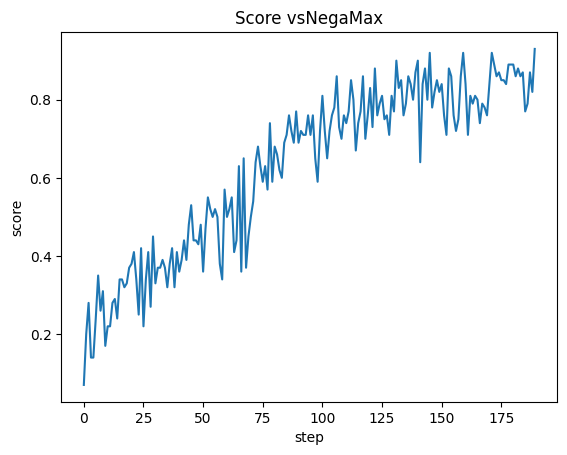

In [35]:
# First create your AlphaN instance
agent1 = AlphaN()

# Then call train
agent1.train(1000)

Save the Weights

In [36]:
torch.save(agent1.net.state_dict(), 'connectx_weights.pth')

# Visualizing Training Progress for ConnectX AI

```python
# Plot total loss (policy + value loss combined)
plt.plot(agent1.loss_log)
plt.title('total loss')
plt.xlabel('loop')
plt.ylabel('loss')
plt.show()

# Plot value prediction loss (Mean Squared Error)
plt.plot(agent1.MSE_log)
plt.title('value loss')
plt.xlabel('loop')
plt.ylabel('loss')
plt.show()

# Plot policy prediction loss (Cross Entropy Loss)
plt.plot(agent1.CEL_log)
plt.title('policy loss')
plt.xlabel('loop')
plt.ylabel('loss')
plt.show()
```

These plots track three critical aspects of the model's learning process:

1. **Total Loss Plot**
   - Represents overall learning progress
   - Should show a generally decreasing trend
   - Combines policy and value loss into single metric

2. **Value Loss Plot (MSE)**
   - Tracks how well the model predicts game outcomes
   - Measures position evaluation accuracy
   - Uses Mean Squared Error for measuring prediction accuracy

3. **Policy Loss Plot (CEL)**
   - Shows improvement in move selection
   - Uses Cross Entropy Loss to measure move prediction accuracy
   - Critical for tactical decision-making improvement

Monitoring these metrics helps:
- Identify learning problems early
- Understand which aspects need improvement
- Determine when to stop training
- Guide hyperparameter adjustments

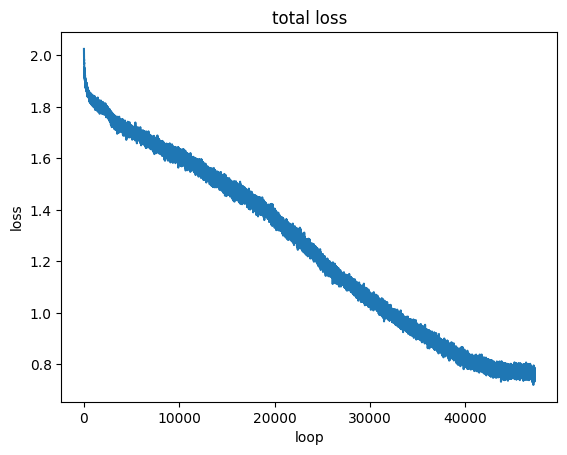

In [37]:
plt.plot(agent1.loss_log)
plt.title('total loss')
plt.xlabel('loop')
plt.ylabel('loss')
plt.show()

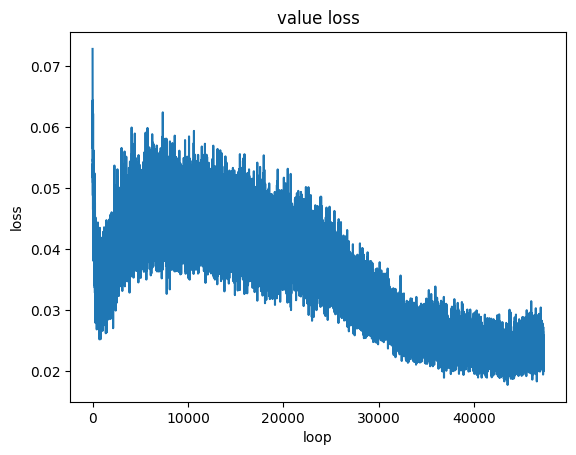

In [38]:
plt.plot(agent1.MSE_log)
plt.title('value loss')
plt.xlabel('loop')
plt.ylabel('loss')
plt.show()

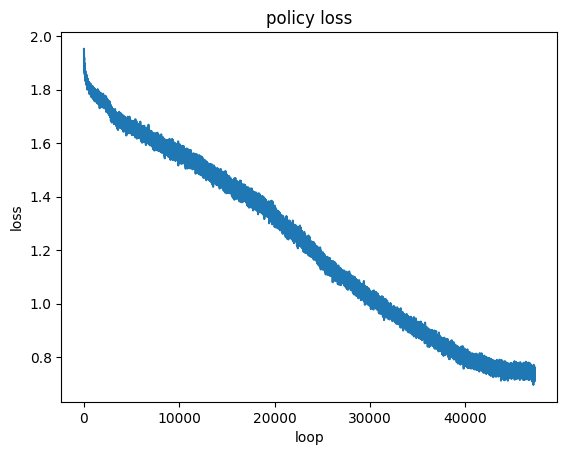

In [39]:
plt.plot(agent1.CEL_log)
plt.title('policy loss')
plt.xlabel('loop')
plt.ylabel('loss')
plt.show()

# ConnectX AI Agent - Submission File Generator

## Overview
This notebook generates a self-contained submission file for the ConnectX game competition on Kaggle. It packages our trained AI model, including the network architecture and MCTS implementation, into a single deployable file.

## Implementation Details

### 1. Setup Configuration
```python
# Configure NumPy output settings
np.set_printoptions(threshold=np.inf)

# Initialize output string for submission file
out = """
# Required imports
from kaggle_environments.envs.connectx.connectx import play,is_win
import time
import random
import torch
import numpy as np
"""
```

### 2. Neural Network and MCTS Implementation
```python
# Add Alpha_Net class definition to output string
out += """
def agent(observation, configuration):
    # Neural network architecture
    class Alpha_Net(torch.nn.Module):
        # ... [network implementation] ...

    # MCTS implementation
    def alpha_MCTS(net, board, config, ...):
        # ... [MCTS code] ...
"""
```

### 3. Model Weight Transfer
```python
# Transfer trained weights to submission format
for key in agent1.net.state_dict().keys():
    if 'num' in key:
        # Handle numerical parameters
        out += f"    net.state_dict()['{key}'] = torch.tensor({str(agent1.net.state_dict()[key].item())})\n"
    else:
        # Handle tensor parameters
        out += f"    net.state_dict()['{key}'][:] = torch.tensor({str(list(agent1.net.state_dict()[key].to(torch.device('cpu')).numpy())).replace('array(', '').replace(')', '').replace(' ', '').replace('\\n', '').replace(',dtype=float32','')})\n"
```

### 4. Agent Implementation
```python
# Add agent decision-making logic
out += """
    # Initialize network with transferred weights
    net = Alpha_Net()
    net.eval()
    
    # Make move selection using MCTS
    with torch.no_grad():
        pol = alpha_MCTS(net, observation.board, configuration, start_time=start_time, root=True)
    action = int(np.argmax(np.array(pol)))
    
    # Fallback to random valid move if selected column is full
    if observation.board[action] != 0:
        action = random.choice([c for c in range(configuration.columns) if observation.board[c] == 0])
    return action
"""
```

### 5. Generate Submission File
```python
# Write complete agent code to submission file
with open('submission.py', 'w') as f:
    f.write(out)
```

## Usage
Run all cells in this notebook after training your model to generate a submission-ready file. The generated `submission.py` can be uploaded directly to the Kaggle ConnectX competition.

**Note**: Ensure your trained model (`agent1`) is loaded and available in the notebook environment before running this code.

In [40]:
np.set_printoptions(threshold=np.inf)

In [41]:
out = """
from kaggle_environments.envs.connectx.connectx import play,is_win
import time
import random
import torch
import numpy as np
def agent(observation,configuration):
    start_time = time.time()
    class Alpha_Net(torch.nn.Module):
        def __init__(self):
            super(Alpha_Net,self).__init__()
            self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(2,20,kernel_size=2,padding=0,stride=1),
            torch.nn.BatchNorm2d(20),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(20,40,kernel_size=3,padding=0,stride=1),
            torch.nn.BatchNorm2d(40),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(40,120,kernel_size=3,padding=0,stride=1),
            torch.nn.BatchNorm2d(120),
            torch.nn.LeakyReLU(),
            )
            self.block2 = torch.nn.Sequential(
            torch.nn.Linear(240, 42),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(42, 7),
            )
            self.t_out = torch.nn.LogSoftmax(dim=1)
            self.e_out = torch.nn.Softmax(dim=1)
            self.block3 = torch.nn.Sequential(
            torch.nn.Linear(240, 16),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(16, 1),
            torch.nn.Tanh()
            )

        def forward(self, x):
            x = self.block1(x)
            x = x.view(-1,240)
            x1 = self.block2(x)
            if self.training:
                x1 = self.t_out(x1)
            else:
                x1 = self.e_out(x1)
            x2 = self.block3(x)
            x = torch.cat([x1,x2],dim=1)
            return x
    def alpha_MCTS(net,board,config,start_time=None,info=None,expand=False,root=False,C_p=1000,expand_threshold=1,time_lim=2.0,gamma=0.95,steps=10000000):
        if info == None:
            b1 = np.array([[[1 if p == 1 else 0 for p in board]]]).reshape(1,1,6,7)
            b2 = np.array([[[1 if p == 2 else 0 for p in board]]]).reshape(1,1,6,7)
            board2 = np.concatenate([b1,b2],axis=1)
            board2 = torch.from_numpy(board2).float()
            pred = net(board2).detach().numpy()[0]
            policy = pred[:7]
            value = pred[7]
            count = [0,0,0,0,0,0,0]
            info_each = [0,0,0,0,0,0,0]
            Q = [0,0,0,0,0,0,0]
        else:
            policy = info['policy']
            info_each = info['info_each']
            count = info['count']
            Q = info['Q']
            value = info['value']
        turn = sum([1 if p != 0 else 0 for p in board])%2 + 1
        if root:
            for t in range(steps):
                C = np.log((1+sum(count)+C_p)/C_p) + 1.25
                select = np.array([Q[i]+C*policy[i]*(np.sqrt(sum(count))/(1+count[i])) for i in range(7)])
                child_index = int(np.argmax(select))
                if board[child_index] != 0:
                    Q[child_index] = -1
                else:
                    next_board = board[:]
                    if is_win(next_board,child_index,turn,config,False):
                        Q[child_index] = 1
                    else:
                        play(next_board,child_index,turn,config)
                        fillness = sum([1 if p != 0 else 0 for p in next_board])
                        if fillness == 42:
                            Q[child_index] = 0
                        else:
                            if count[child_index] >= expand_threshold:
                                scc, ie = alpha_MCTS(net,next_board,config,start_time,expand=True,info=info_each[child_index])
                                Q[child_index] = -scc
                                info_each[child_index] = ie
                            else:
                                if count[child_index] == 0:
                                    scc, pol = alpha_MCTS(net,next_board,config,start_time,info=None)
                                    Q[child_index] = -scc
                                    info_each[child_index] = {'policy':pol,'info_each':[0,0,0,0,0,0,0],'count':[0,0,0,0,0,0,0],'Q':[0,0,0,0,0,0,0],'value':scc}
                count[child_index] += 1
                if time.time()-start_time >= time_lim:
                    break
            return np.power(np.array(count),1) / np.power(np.array(count),1).sum()
        else:
            if expand:
                C = np.log((1+sum(count)+C_p)/C_p) + 1.25
                select = np.array([Q[i]+C*policy[i]*(np.sqrt(sum(count))/(1+count[i])) for i in range(7)])
                child_index = int(np.argmax(select))
                if board[child_index] != 0:
                    Q[child_index] = -1
                else:
                    next_board = board[:]
                    if is_win(next_board,child_index,turn,config,False):
                        Q[child_index] = 1
                    else:
                        play(next_board,child_index,turn,config)
                        fillness = sum([1 if p != 0 else 0 for p in next_board])
                        if fillness == 42:
                            Q[child_index] = 0
                        else:
                            if count[child_index] >= expand_threshold:
                                scc, ie = alpha_MCTS(net,next_board,config,start_time,expand=True,info=info_each[child_index])
                                Q[child_index] = -gamma*scc
                                info_each[child_index] = ie
                            else:
                                if count[child_index] == 0:
                                    scc, pol = alpha_MCTS(net,next_board,config,start_time,info=None)
                                    Q[child_index] = -gamma*scc
                                    info_each[child_index] = {'policy':pol,'info_each':[0,0,0,0,0,0,0],'count':[0,0,0,0,0,0,0],'Q':[0,0,0,0,0,0,0],'value':scc}
                count[child_index] += 1
                re_Q = np.array(Q) * np.array(count)
                r = np.power(2,sum(count)-1)/(1+np.power(2,sum(count)-1))
                return np.sum(re_Q)/sum(count)*r + value*(1-r), {'policy':policy,'info_each':info_each,'count':count,'Q':Q,'value':value}
            else:
                return value, policy
    net = Alpha_Net()
"""
for key in agent1.net.state_dict().keys():
    if 'num' in key:
        out += "    net.state_dict()['"+key+"'] = torch.tensor("+str(agent1.net.state_dict()[key].item())+")\n"
    else:
        out += "    net.state_dict()['"+key+"'][:] = torch.tensor("+str(list(agent1.net.state_dict()[key].to(torch.device("cpu")).numpy())).replace('array(', '').replace(')', '').replace(' ', '').replace('\n', '').replace(',dtype=float32','')+")\n"
out += """
    net.eval()
    with torch.no_grad():
        pol = alpha_MCTS(net,observation.board,configuration,start_time=start_time,root=True)
    action = int(np.argmax(np.array(pol)))
    if observation.board[action] != 0:
        action = random.choice([c for c in range(configuration.columns) if observation.board[c] == 0])
    return action"""

In [42]:
with open('submission.py', 'w') as f:
    f.write(out)

Test Submission and Evaluate

In [43]:
from submission import agent

In [46]:
env = make("connectx", debug=True)
trainer = env.train(["negamax",None])

observation = trainer.reset()

while not env.done:
    my_action = agent(observation, env.configuration)
    print("My Action", my_action)
    observation, reward, done, info = trainer.step(my_action)
env.render()
print(reward)

My Action 3
My Action 3
My Action 0
My Action 3
My Action 3
My Action 3
My Action 1
My Action 1
My Action 1
My Action 2
My Action 2
My Action 2
My Action 5
My Action 5
My Action 6
My Action 5
My Action 6
My Action 6
My Action 4
+---+---+---+---+---+---+---+
| 1 | 2 | 2 | 2 | 0 | 2 | 2 |
+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 2 | 0 | 1 | 1 |
+---+---+---+---+---+---+---+
| 2 | 2 | 2 | 1 | 0 | 2 | 2 |
+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 2 | 0 | 1 | 1 |
+---+---+---+---+---+---+---+
| 1 | 2 | 2 | 2 | 2 | 2 | 2 |
+---+---+---+---+---+---+---+
| 1 | 1 | 1 | 2 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+

1
